<a id="contents"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Contents</b>
</div>
<hr>

- [**Imports**](#imports)
- [**Functions**](#functions)
- [**Plots**](#plots)
    - [**Apprecition rate**](#appreciation_rate)
    - [**Discount rate**](#discount_rate)
    - [**Mortgage rate**](#mortgage_rate)
    - [**Downpayment percentage**](#downpayment_percentage)
    - [**Mortgage term**](#mortgage_term)
    - [**Agency percentage**](#agency_percentage)
    - [**Capital gain tax percentage**](#capital_gain_tax_percentage)
    - [**Analysis horizon**](#analysis_horizon)
    - [**Initial house price**](#initial_house_price)
    - [**Condo fee and maintenance**](#condo_fee_and_maintenance)
    - [**Utilities**](#utilities)
    - [**Monthly rent payment**](#rent_payment_monthly)

<a id="imports"></a>
<div style="background-color:gray; font-size: 30px;">
<b style="color: white;">Imports</b>
</div>

In [65]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<a id="functions"></a>
<div style="background-color:gray; font-size: 30px;">
<b style="color: white;">Functions</b>
</div>

In [66]:
def rate_y_to_m(rate_yearly, rate_type="nominal"):
    """Convert nominal or effective yearly rate to effective monthly rate."""
    if rate_type == "nominal":
        rate_monthly = rate_yearly / 12
    else:
        rate_monthly = (1 + rate_yearly) ** (1 / 12) - 1
    return rate_monthly

# amounts - array of supposedly contiguous time index
# paying at the end of each month
# offset is the first time unit when we start paying
# (t, p) - index, value.
def PV(cash_flow, r_d=0.05, offset=1):
    """Compute present value of a cash flow."""
    pv = sum(p / (1 + r_d)**t for t, p in enumerate(cash_flow, start=offset))
    return pv


def mortgage_payment(mortgage, r_m, T):
    """Compute monthly mortgage payments."""
    payment = mortgage * (1 + r_m)**T * r_m / ((1 + r_m)**T - 1)
    return payment


def mortgage_debt(mortgage, payment, r_m, t):
    """Compute unpaid mortgage at a given time."""
    unpaid_mortgage = mortgage * (1 + r_m)**t - payment * ((1 + r_m)**t - 1) / r_m
    return unpaid_mortgage

In [67]:
def calculate(
    r_a_yearly=0.01,
    r_d_yearly=0.0375,
    r_m_yearly=0.04,
    downpayment_percentage=0.2,
    agency_percentage=0.06,
    capital_gain_tax_percentage=0.1,
    T_years=30,
    H_years=5,
    initial_house_price=400_000,
    condo_fee_and_maintenance=700+50,
    utilities=200,
    rent_payment_monthly=1_800
):
    """Calculate basic mortgage characteristics."""
    
    # Rates and percentages
    r_a_monthly = rate_y_to_m(r_a_yearly)
    r_d_monthly = rate_y_to_m(r_d_yearly)
    r_m_monthly = rate_y_to_m(r_m_yearly)

    mortgage_percentage = 1 - downpayment_percentage

    # Time
    T_months = 12 * T_years
    H_months = 12 * H_years

    # Mortgage payments
    mortgage = mortgage_percentage * initial_house_price
    mortgage_payment_monthly = mortgage_payment(mortgage, r_m_monthly, T_months)
    all_ownership_expenses_monthly = (np.repeat(mortgage_payment_monthly, H_months) +
                                 (condo_fee_and_maintenance + utilities) * (1 + r_a_monthly)**np.arange(1, H_months + 1))
    negative_ownership_payments_pv = -PV(all_ownership_expenses_monthly, r_d_monthly)
    # stopped here
    # House selling
    future_house_price = initial_house_price * (1 + r_a_yearly) ** H_years
    commission_and_tax = (
        agency_percentage * future_house_price
        + capital_gain_tax_percentage * (future_house_price - initial_house_price)
    )
    unpaid_mortgage = mortgage_debt(
        mortgage, mortgage_payment_monthly, r_m_monthly, H_months
    )
    net_revenue = future_house_price - commission_and_tax - unpaid_mortgage
    mortgage_pv_plus = PV([net_revenue], r_d_monthly, H_months)

    # Rent payments
    rent_monthly = (np.repeat(rent_payment_monthly, H_months) +
                    utilities * (1 + r_a_monthly)**np.arange(1, H_months + 1))
    rent_pv_minus = -PV(rent_monthly, r_d_monthly)

    # Interest
    downpayment = downpayment_percentage * initial_house_price
    rent_pv_plus = downpayment

    mortgage_pv = mortgage_pv_plus + negative_ownership_payments_pv
    rent_pv = rent_pv_plus + rent_pv_minus
    net_purchase_benefit = mortgage_pv - rent_pv

    return {
        "Future house price": future_house_price,
        "Net revenue": net_revenue,
        "Mortgage NPV": mortgage_pv_plus + negative_ownership_payments_pv,
        "Rent NPV": rent_pv_plus + rent_pv_minus,
        "Net purchase benefit": net_purchase_benefit,
        "Mortgage payment monthly": mortgage_payment_monthly
    }

In [68]:
def plot_results(results, kwargs, key, fixed):
    """Plot mortgage characteristics."""
    fig, axes = plt.subplot_mosaic([["ax1", "ax2"], ["ax3", "ax4"], ["ax5", "ax6"]], figsize=(9, 9))

    fixed_title = ""
    if len(fixed):
        fixed_title = "Fixed arguments: " + ", ".join([f"{k}={v}" for k, v in fixed.items()])

    fig.suptitle(
        f"Changing Argument: {key} (min={min(kwargs[key]):.2f}, max={max(kwargs[key]):.2f})\n{fixed_title}",
        fontproperties={"size": 16, "weight": "bold"}
    )

    axes_titles = {
        "ax1": "Future house price",
        "ax2": "Net revenue",
        "ax3": "Mortgage NPV",
        "ax4": "Rent NPV",
        "ax5": "Mortgage payment monthly",
        "ax6": "Net purchase benefit"
    }

    for ax, ax_title in axes_titles.items():
        axes[ax].set_title(ax_title, fontdict={"size": 14, "weight": "bold"})
        axes[ax].plot(kwargs[key], results[ax_title], marker="o")
        axes[ax].grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

In [69]:
def print_table(results, changing_arg):
    """Print mortgage characteristics in a pandas dataframe."""
    display(pd.DataFrame(results, index=changing_arg).map(lambda x: f"{x:,.0f}"))

In [70]:
def run(**kwargs):
    """Calculate mortgage characteristics for different values of a given parameter."""
    runnable_keys = [k for k, v in kwargs.items() if isinstance(v, (np.ndarray, list))]
    assert len(runnable_keys) == 1, "Exactly one runnable argument is required!"
    runnable_key = runnable_keys[0]

    fixed = {k: v for k, v in kwargs.items() if not isinstance(v, (np.ndarray, list))}

    run_args = fixed.copy()
    results = collections.defaultdict(list)
    for value in kwargs[runnable_key]:
        run_args[runnable_key] = value
        for k, v in calculate(**run_args).items():
            results[k].append(v)

    plot_results(results, kwargs, runnable_key, fixed)
    print_table(results, kwargs[runnable_key])

<a id="plots"></a>
<div style="background-color:gray; font-size: 30px;">
<b style="color: white;">Plots</b>
</div>

In [71]:
calculate()

{'Future house price': 420404.02004000003,
 'Net revenue': 103707.33479810855,
 'Mortgage NPV': np.float64(-50664.07595705634),
 'Rent NPV': np.float64(-29539.816698640556),
 'Net purchase benefit': np.float64(-21124.259258415783),
 'Mortgage payment monthly': 1527.7289454894521}

<a id="appreciation_rate"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Appreciation rate</b>
</div>

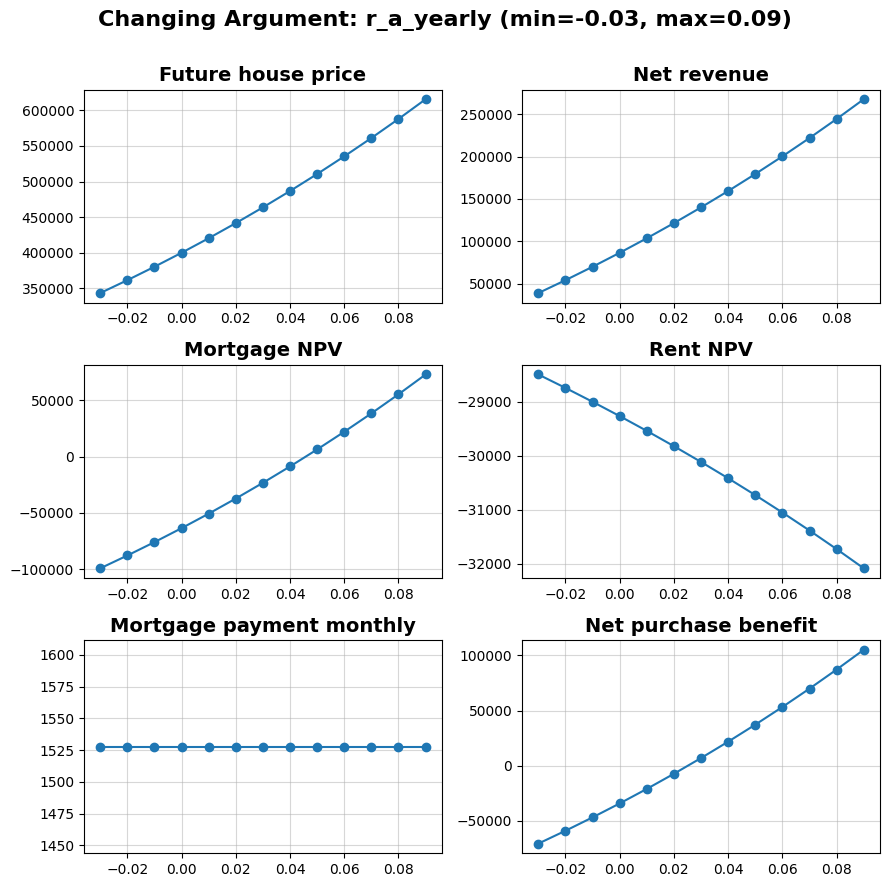

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
-3.000000e-02,"343,494","39,103","-99,282","-28,496","-70,786","1,528"
-2.000000e-02,"361,568","54,285","-87,872","-28,745","-59,127","1,528"
-1.000000e-02,"380,396","70,101","-75,975","-29,001","-46,974","1,528"
6.938894e-18,"400,000","86,568","-63,578","-29,266","-34,311","1,528"
1.000000e-02,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
2.000000e-02,"441,632","121,539","-37,219","-29,822","-7,397","1,528"
3.000000e-02,"463,710","140,084","-23,227","-30,114","6,887","1,528"
4.000000e-02,"486,661","159,363","-8,672","-30,416","21,744","1,528"
5.000000e-02,"510,513","179,399","6,463","-30,728","37,190","1,528"
6.000000e-02,"535,290","200,212","22,193","-31,050","53,243","1,528"


In [72]:
run(r_a_yearly=np.arange(-0.03, 0.1, 0.01))

<a id="discount_rate"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Discount rate</b>
</div>

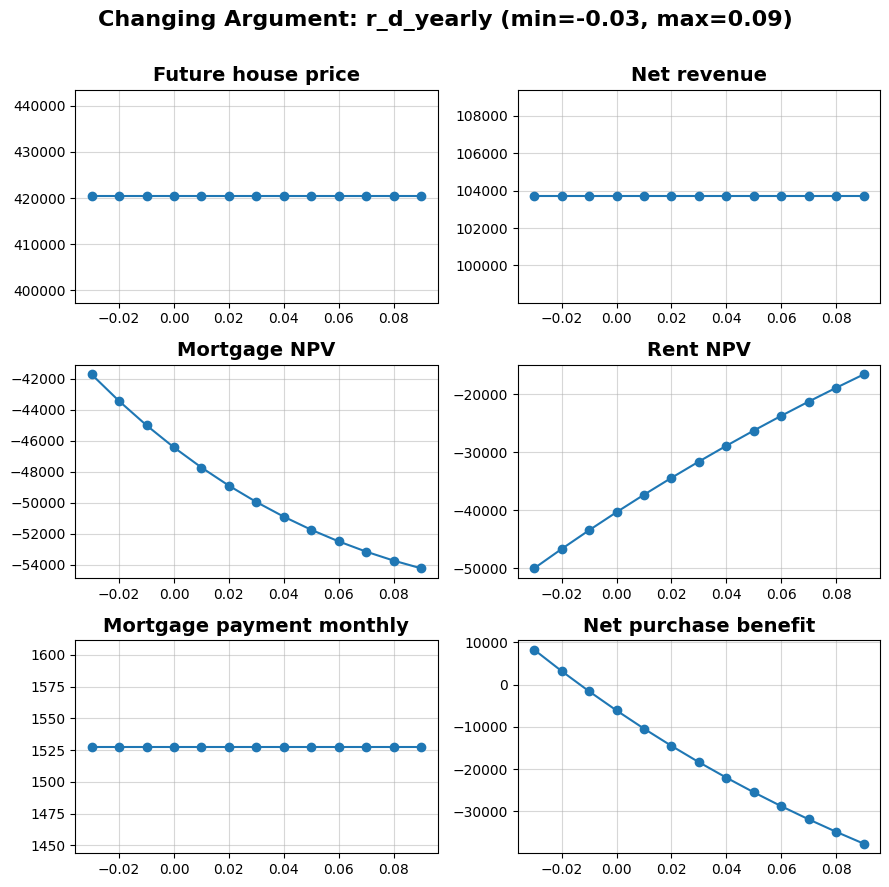

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
-3.000000e-02,"420,404","103,707","-41,726","-49,985","8,259","1,528"
-2.000000e-02,"420,404","103,707","-43,440","-46,648","3,207","1,528"
-1.000000e-02,"420,404","103,707","-45,005","-43,424","-1,581","1,528"
6.938894e-18,"420,404","103,707","-46,429","-40,310","-6,119","1,528"
1.000000e-02,"420,404","103,707","-47,722","-37,302","-10,420","1,528"
2.000000e-02,"420,404","103,707","-48,891","-34,395","-14,497","1,528"
3.000000e-02,"420,404","103,707","-49,945","-31,585","-18,360","1,528"
4.000000e-02,"420,404","103,707","-50,891","-28,869","-22,021","1,528"
5.000000e-02,"420,404","103,707","-51,734","-26,244","-25,490","1,528"
6.000000e-02,"420,404","103,707","-52,483","-23,705","-28,778","1,528"


In [73]:
run(r_d_yearly=np.arange(-0.03, 0.1, 0.01))

<a id="mortgage_rate"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Mortgage rate</b>
</div>

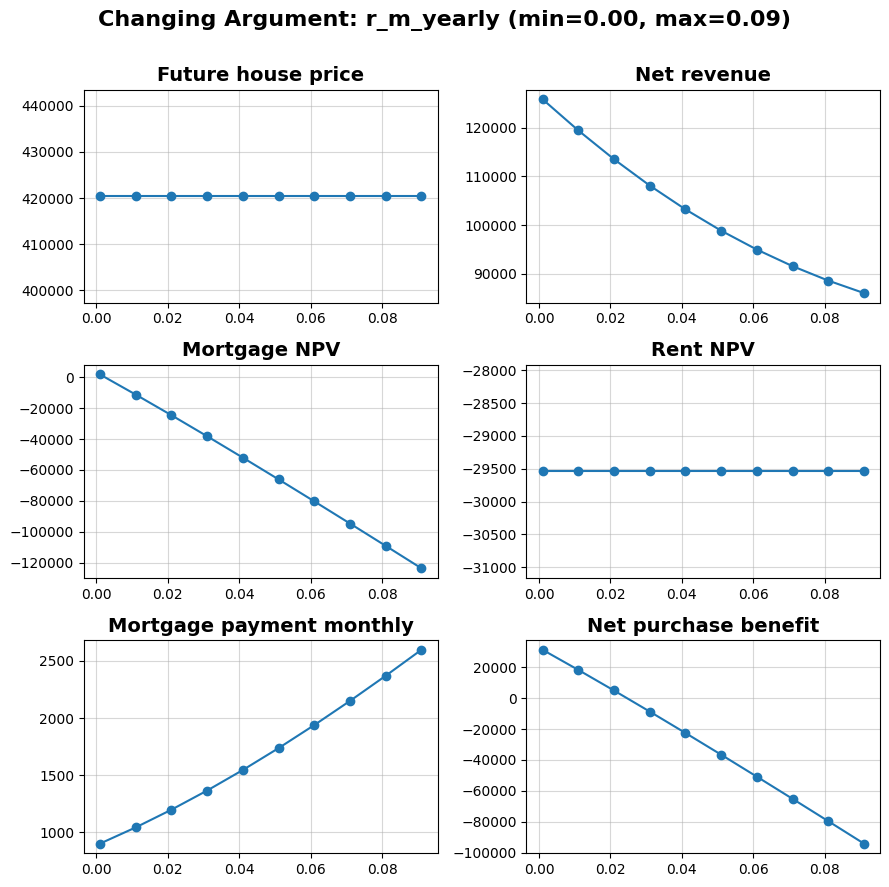

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0.001,"420,404","125,808","1,831","-29,540","31,371",902
0.011,"420,404","119,420","-11,207","-29,540","18,333","1,044"
0.021,"420,404","113,518","-24,561","-29,540","4,979","1,199"
0.031,"420,404","108,123","-38,192","-29,540","-8,652","1,366"
0.041,"420,404","103,242","-52,061","-29,540","-22,521","1,546"
0.051,"420,404","98,873","-66,130","-29,540","-36,590","1,737"
0.061,"420,404","95,000","-80,364","-29,540","-50,824","1,939"
0.071,"420,404","91,599","-94,730","-29,540","-65,190","2,151"
0.081,"420,404","88,639","-109,197","-29,540","-79,658","2,370"
0.091,"420,404","86,085","-123,742","-29,540","-94,202","2,598"


In [74]:
run(r_m_yearly=np.arange(0.001, 0.1, 0.01))

<a id="downpayment_percentage"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Downpayment percentage</b>
</div>

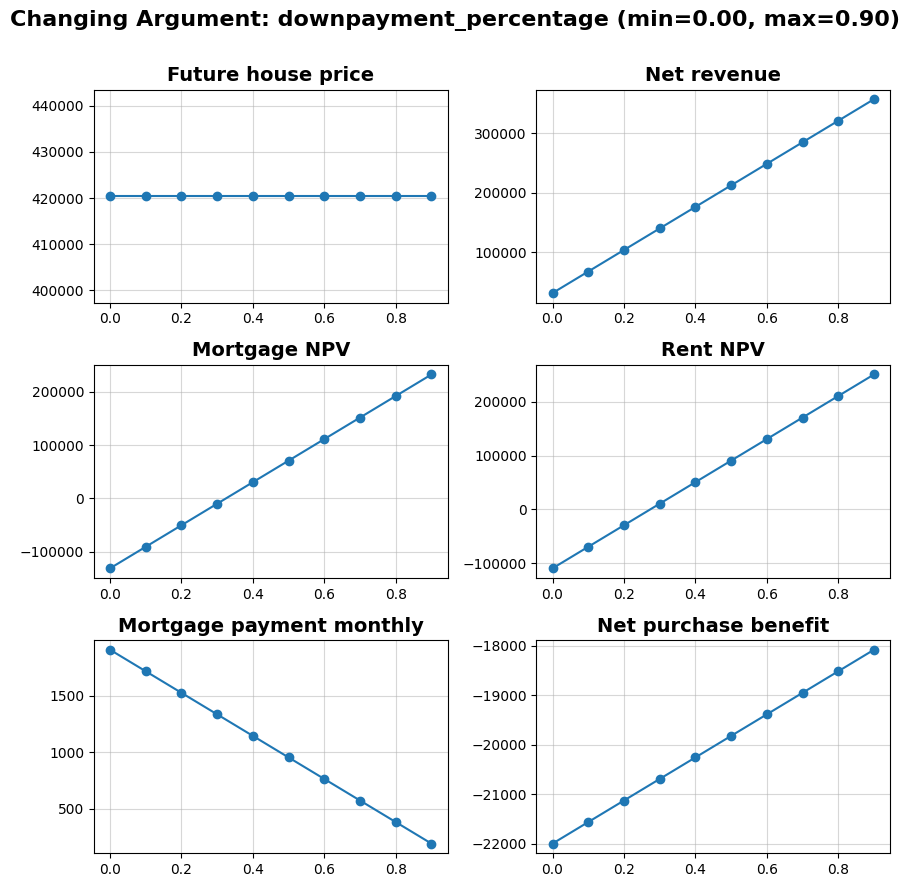

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0.0,"420,404","31,349","-131,535","-109,540","-21,995","1,910"
0.1,"420,404","67,528","-91,099","-69,540","-21,560","1,719"
0.2,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
0.3,"420,404","139,886","-10,229","10,460","-20,689","1,337"
0.4,"420,404","176,065","30,207","50,460","-20,254","1,146"
0.5,"420,404","212,244","70,642","90,460","-19,818",955
0.6,"420,404","248,423","111,077","130,460","-19,383",764
0.7,"420,404","284,602","151,512","170,460","-18,948",573
0.8,"420,404","320,781","191,948","210,460","-18,513",382
0.9,"420,404","356,960","232,383","250,460","-18,077",191


In [75]:
run(downpayment_percentage=np.arange(0, 1, 0.1))

<a id="mortgage_term"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Mortgage term</b>
</div>

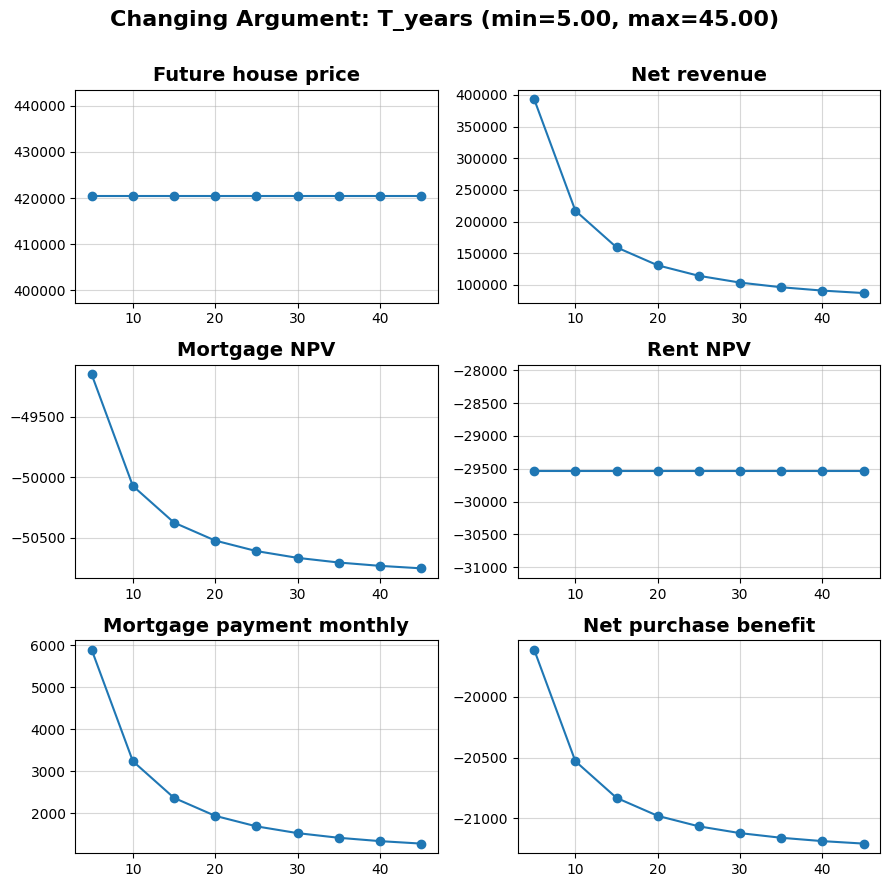

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
5,"420,404","393,139","-49,150","-29,540","-19,611","5,893"
10,"420,404","217,219","-50,070","-29,540","-20,531","3,240"
15,"420,404","159,350","-50,373","-29,540","-20,833","2,367"
20,"420,404","130,983","-50,521","-29,540","-20,982","1,939"
25,"420,404","114,405","-50,608","-29,540","-21,068","1,689"
30,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
35,"420,404","96,358","-50,703","-29,540","-21,163","1,417"
40,"420,404","91,089","-50,730","-29,540","-21,190","1,337"
45,"420,404","87,194","-50,750","-29,540","-21,211","1,279"


In [76]:
# run(T_years=np.arange(10, 50, 10), H_years=7)
run(T_years=np.arange(5, 50, 5))

<a id="agency_percentage"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Agency percentage</b>
</div>

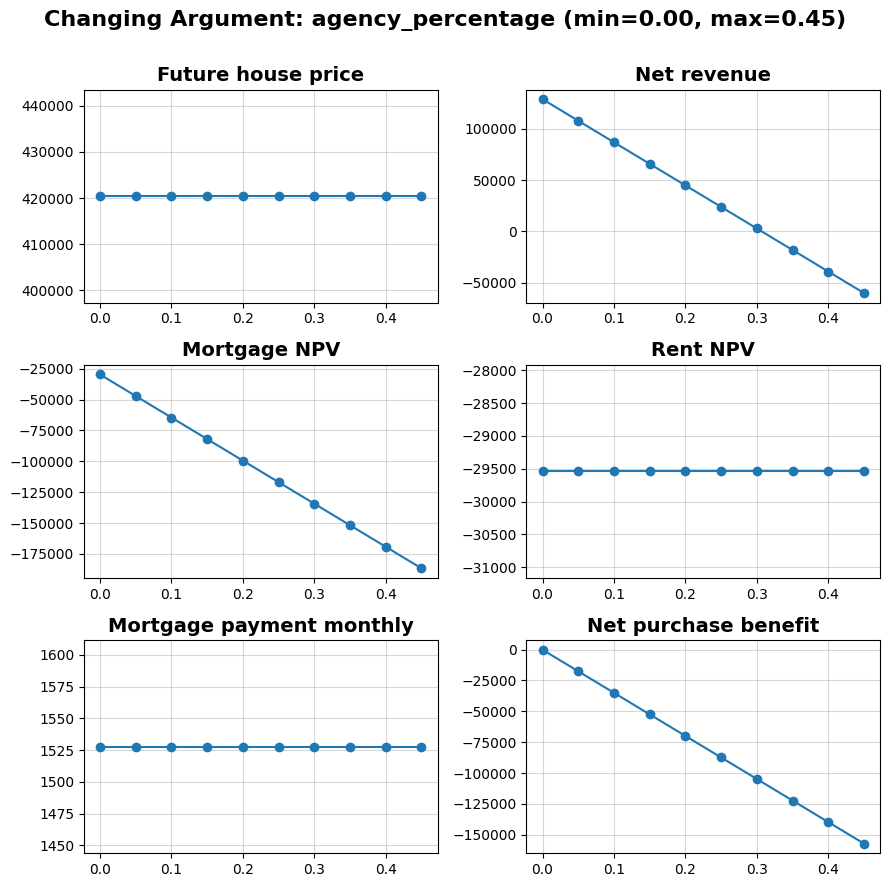

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0.00,"420,404","128,932","-29,746","-29,540",-207,"1,528"
0.05,"420,404","107,911","-47,178","-29,540","-17,638","1,528"
0.10,"420,404","86,891","-64,609","-29,540","-35,069","1,528"
0.15,"420,404","65,871","-82,041","-29,540","-52,501","1,528"
0.20,"420,404","44,851","-99,472","-29,540","-69,932","1,528"
0.25,"420,404","23,831","-116,904","-29,540","-87,364","1,528"
0.30,"420,404","2,810","-134,335","-29,540","-104,795","1,528"
0.35,"420,404","-18,210","-151,767","-29,540","-122,227","1,528"
0.40,"420,404","-39,230","-169,198","-29,540","-139,658","1,528"
0.45,"420,404","-60,250","-186,629","-29,540","-157,090","1,528"


In [77]:
run(agency_percentage=np.arange(0, 0.5, 0.05))

<a id="capital_gain_tax_percentage"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Capital gain tax percentage</b>
</div>

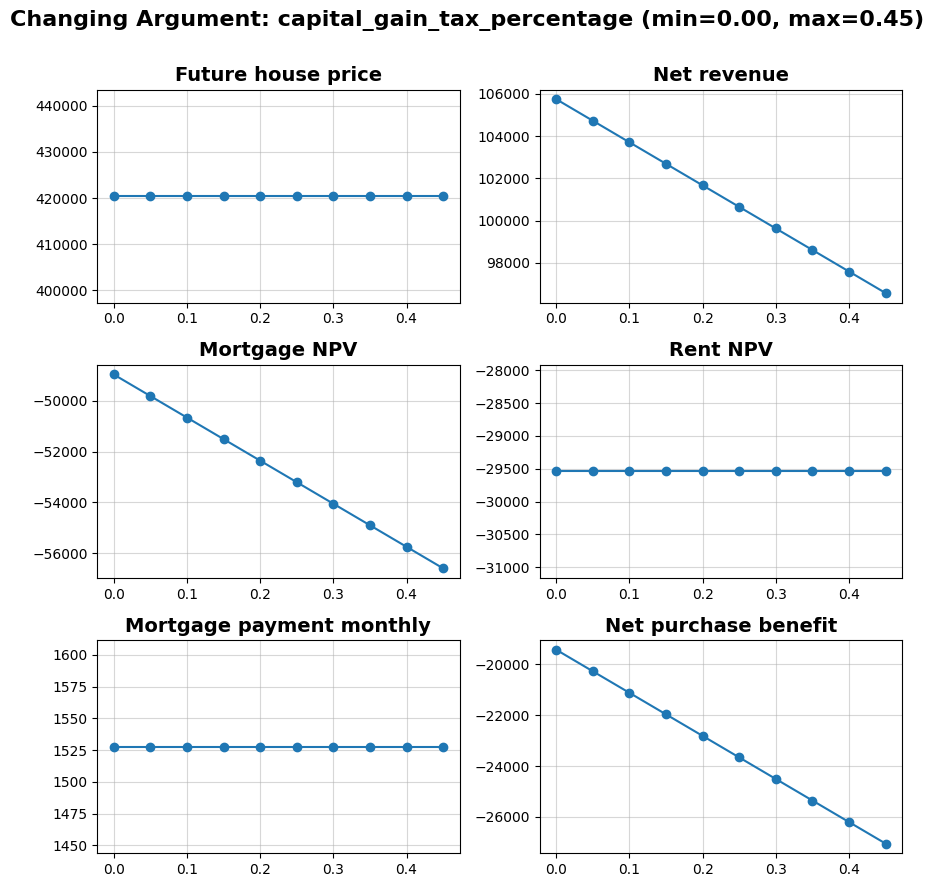

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0.00,"420,404","105,748","-48,972","-29,540","-19,432","1,528"
0.05,"420,404","104,728","-49,818","-29,540","-20,278","1,528"
0.10,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
0.15,"420,404","102,687","-51,510","-29,540","-21,970","1,528"
0.20,"420,404","101,667","-52,356","-29,540","-22,816","1,528"
0.25,"420,404","100,647","-53,202","-29,540","-23,662","1,528"
0.30,"420,404","99,627","-54,048","-29,540","-24,508","1,528"
0.35,"420,404","98,606","-54,894","-29,540","-25,354","1,528"
0.40,"420,404","97,586","-55,740","-29,540","-26,200","1,528"
0.45,"420,404","96,566","-56,586","-29,540","-27,046","1,528"


In [78]:
run(capital_gain_tax_percentage=np.arange(0, 0.5, 0.05))

<a id="analysis_horizon"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Analysis horizon</b>
</div>

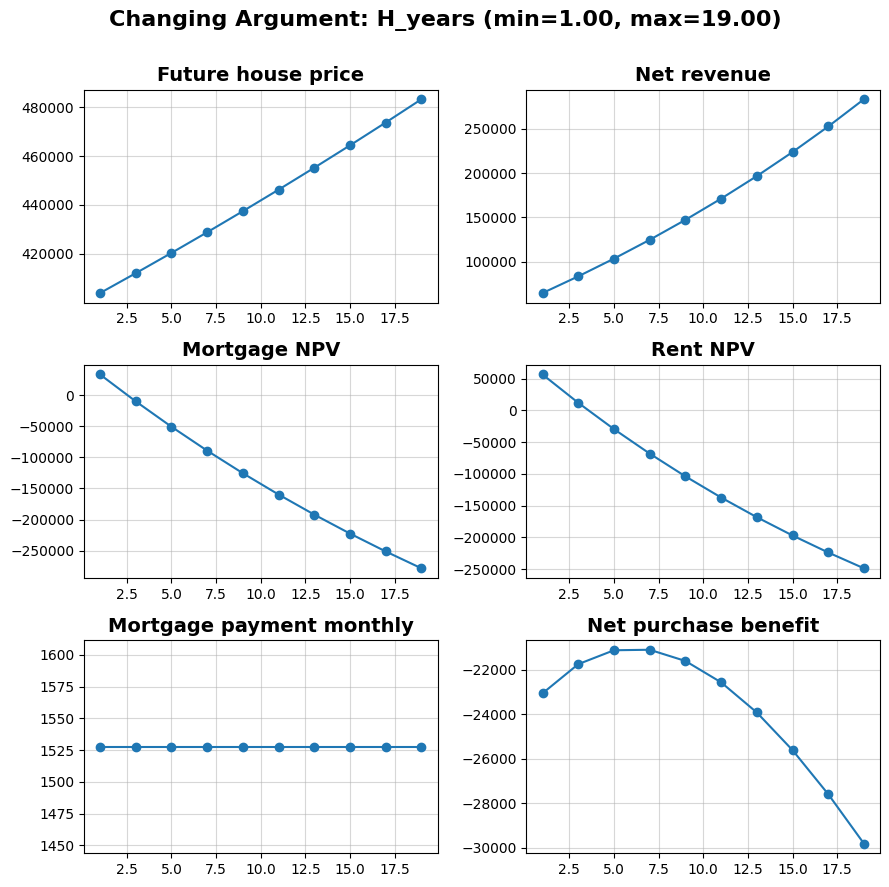

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
1,"404,000","64,995","33,409","56,468","-23,059","1,528"
3,"412,120","83,785","-9,850","11,899","-21,748","1,528"
5,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
7,"428,854","124,847","-89,171","-68,069","-21,102","1,528"
9,"437,474","147,297","-125,500","-103,895","-21,605","1,528"
11,"446,267","171,157","-159,773","-137,208","-22,565","1,528"
13,"455,237","196,535","-192,105","-168,186","-23,919","1,528"
15,"464,388","223,549","-222,603","-196,993","-25,610","1,528"
17,"473,722","252,323","-251,372","-223,784","-27,588","1,528"
19,"483,244","282,996","-278,507","-248,699","-29,808","1,528"


In [79]:
run(H_years=np.arange(1, 20, 2))

<a id="initial_house_price"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Initial house price</b>
</div>

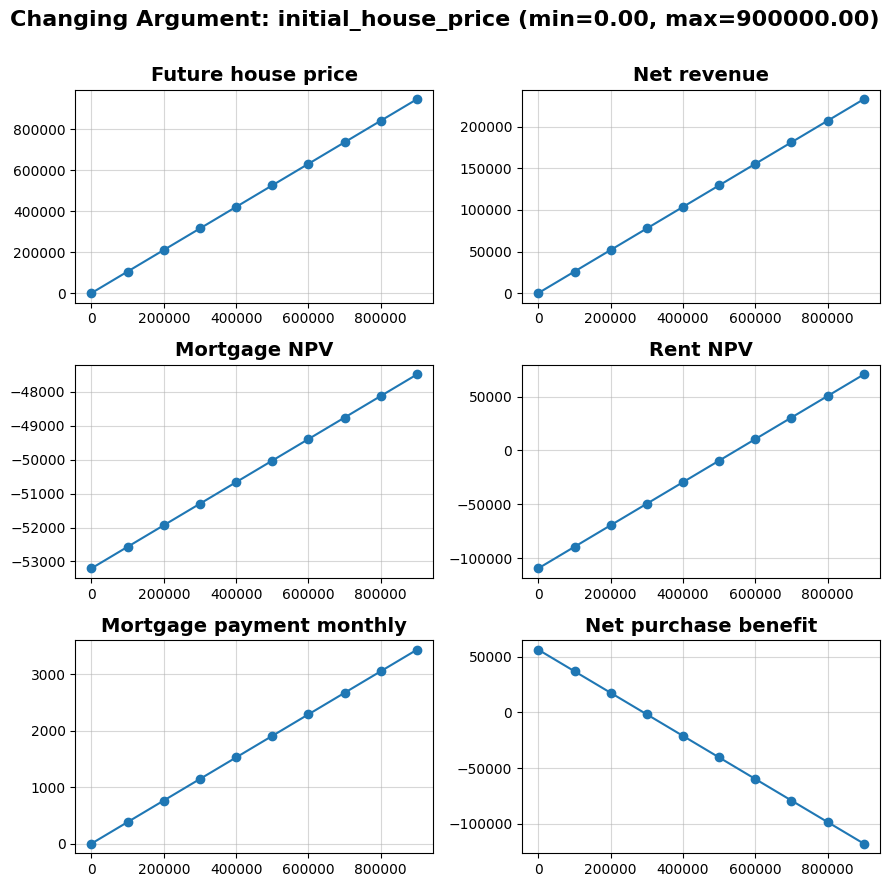

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0,0,0,"-53,201","-109,540","56,339",0
100000,"105,101","25,927","-52,567","-89,540","36,973",382
200000,"210,202","51,854","-51,933","-69,540","17,607",764
300000,"315,303","77,781","-51,298","-49,540","-1,758","1,146"
400000,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
500000,"525,505","129,634","-50,030","-9,540","-40,490","1,910"
600000,"630,606","155,561","-49,396","10,460","-59,856","2,292"
700000,"735,707","181,488","-48,761","30,460","-79,222","2,674"
800000,"840,808","207,415","-48,127","50,460","-98,587","3,055"
900000,"945,909","233,342","-47,493","70,460","-117,953","3,437"


In [80]:
run(initial_house_price=np.arange(0, 1_000_000, 100_000))

Above we can see that cheap condos give more profit. 
In our settings we do not reflect the reality that the cheaper the apartment is, the smaller the equivalent rent it has. 
Instead, we set that whether it cost 0$ or $1m, its equivalent rent is still $1800 a month. 


<a id="condo_fee_and_maintenance"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Condo fee and maintenance</b>
</div>

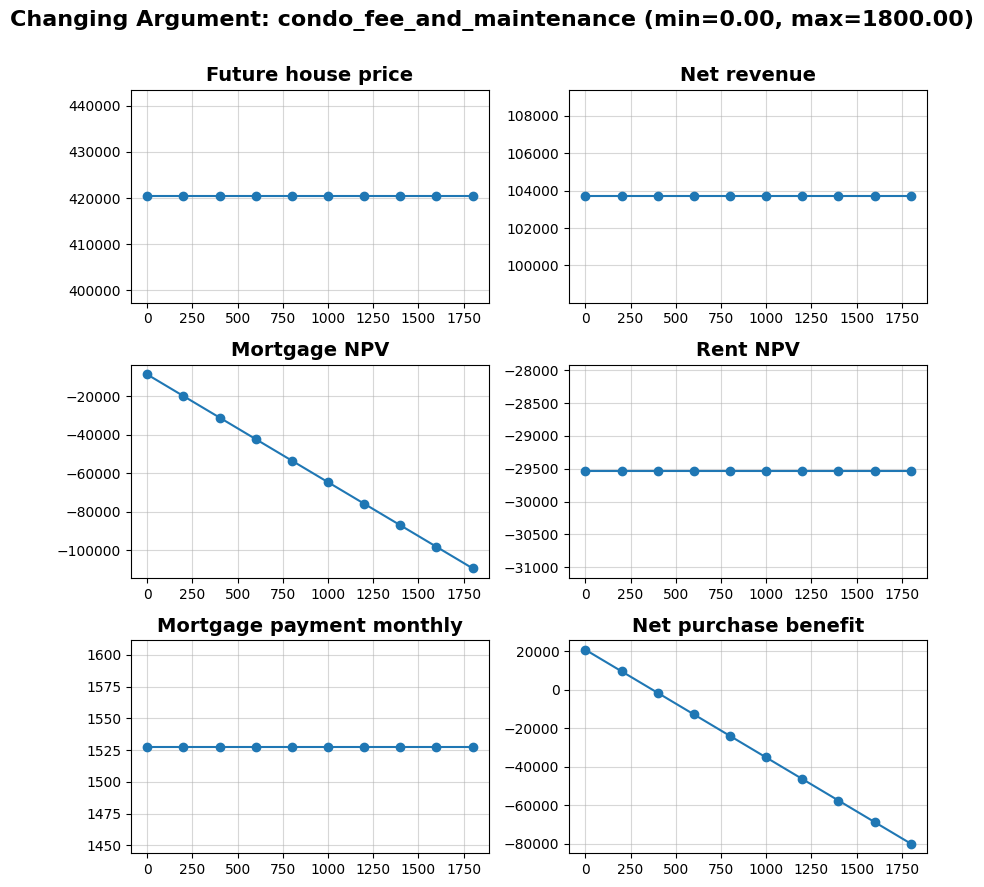

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0,"420,404","103,707","-8,663","-29,540","20,877","1,528"
200,"420,404","103,707","-19,863","-29,540","9,676","1,528"
400,"420,404","103,707","-31,064","-29,540","-1,524","1,528"
600,"420,404","103,707","-42,264","-29,540","-12,724","1,528"
800,"420,404","103,707","-53,464","-29,540","-23,924","1,528"
1000,"420,404","103,707","-64,664","-29,540","-35,125","1,528"
1200,"420,404","103,707","-75,865","-29,540","-46,325","1,528"
1400,"420,404","103,707","-87,065","-29,540","-57,525","1,528"
1600,"420,404","103,707","-98,265","-29,540","-68,725","1,528"
1800,"420,404","103,707","-109,465","-29,540","-79,925","1,528"


In [81]:
run(condo_fee_and_maintenance=np.arange(0, 2_000, 200))

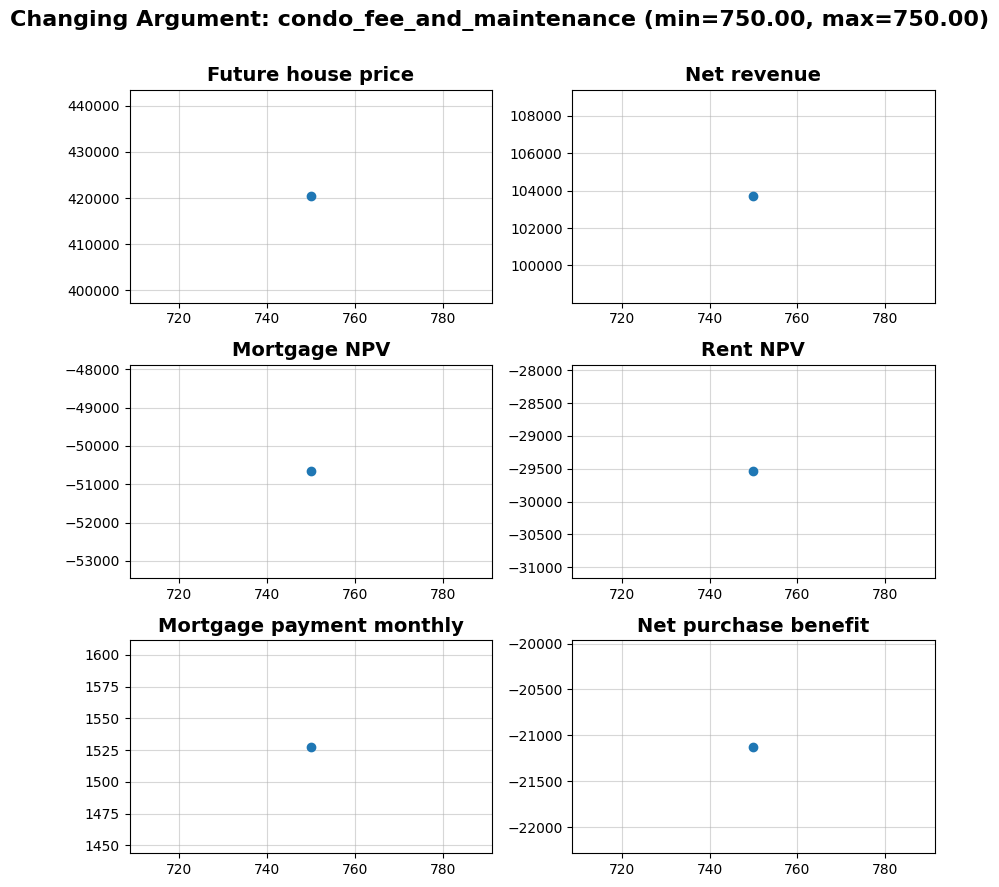

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
750,"420,404","103,707","-50,664","-29,540","-21,124","1,528"


In [82]:
# Just default
run(condo_fee_and_maintenance=np.arange(750, 751, 1))

<a id="utilities"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Utilities</b>
</div>

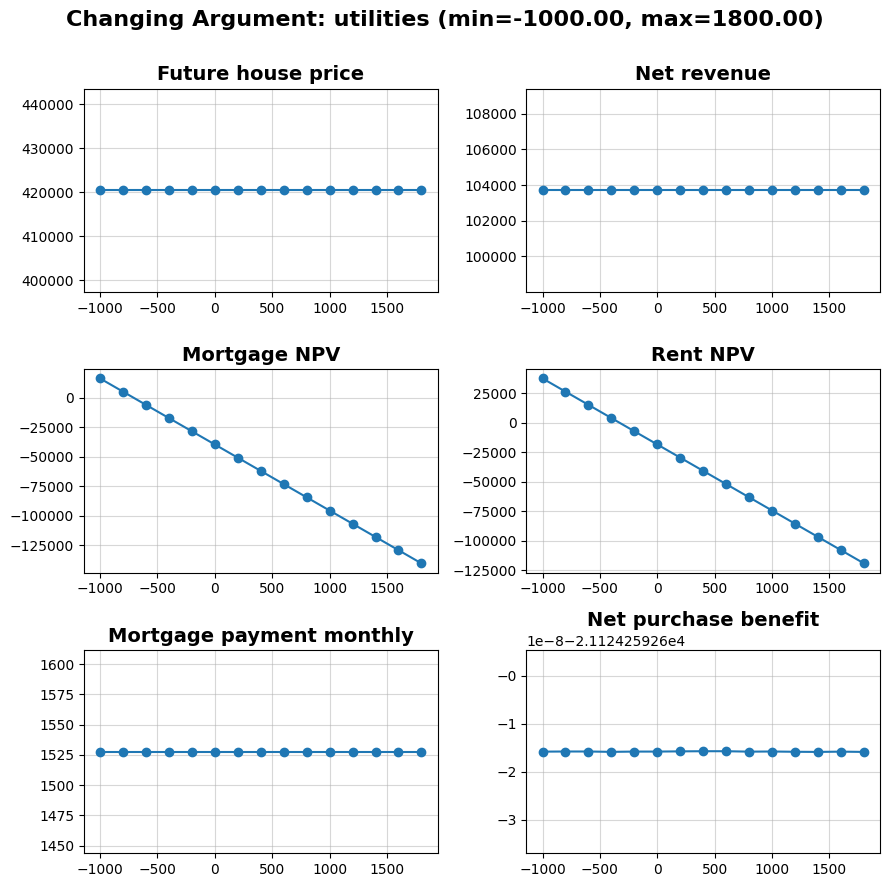

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
-1000,"420,404","103,707","16,537","37,661","-21,124","1,528"
-800,"420,404","103,707","5,337","26,461","-21,124","1,528"
-600,"420,404","103,707","-5,863","15,261","-21,124","1,528"
-400,"420,404","103,707","-17,063","4,061","-21,124","1,528"
-200,"420,404","103,707","-28,264","-7,139","-21,124","1,528"
0,"420,404","103,707","-39,464","-18,340","-21,124","1,528"
200,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
400,"420,404","103,707","-61,864","-40,740","-21,124","1,528"
600,"420,404","103,707","-73,065","-51,940","-21,124","1,528"
800,"420,404","103,707","-84,265","-63,140","-21,124","1,528"


In [83]:
run(utilities=np.arange(-1_000, 2_000, 200))

<a id="rent_payment_monthly"></a>
<div style="background-color:gray; font-size: 25px;">
<b style="color: white;">Monthly rent payment</b>
</div>

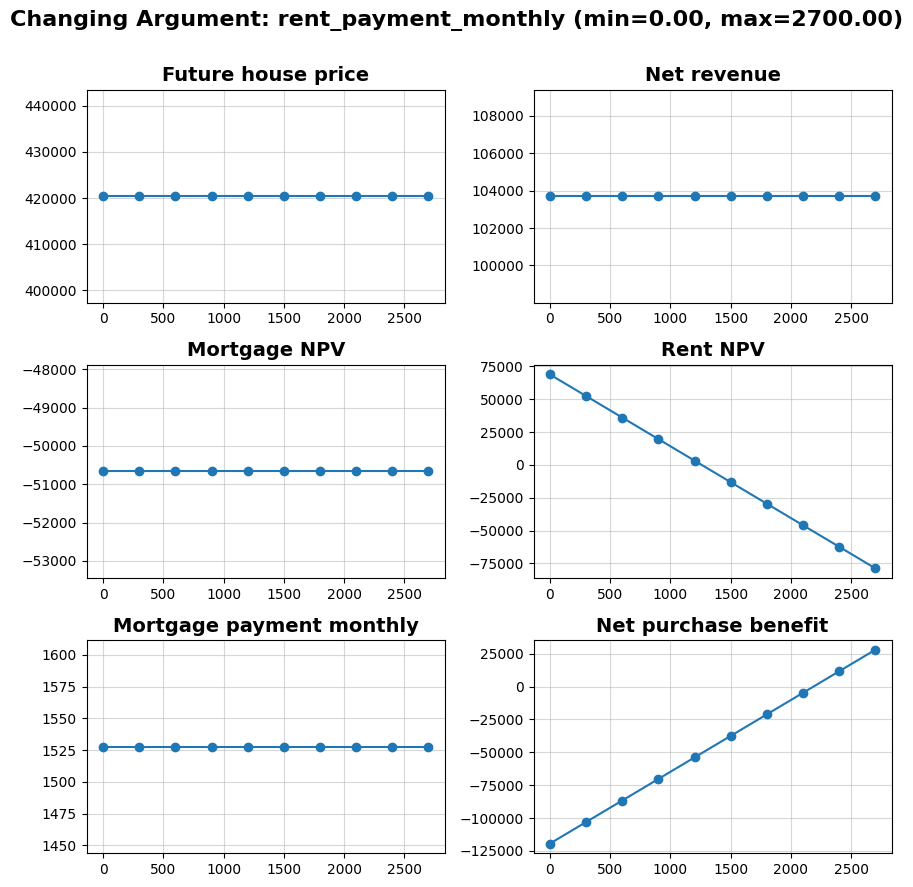

,Future house price,Net revenue,Mortgage NPV,Rent NPV,Net purchase benefit,Mortgage payment monthly
0,"420,404","103,707","-50,664","68,800","-119,464","1,528"
300,"420,404","103,707","-50,664","52,410","-103,074","1,528"
600,"420,404","103,707","-50,664","36,020","-86,684","1,528"
900,"420,404","103,707","-50,664","19,630","-70,294","1,528"
1200,"420,404","103,707","-50,664","3,240","-53,904","1,528"
1500,"420,404","103,707","-50,664","-13,150","-37,514","1,528"
1800,"420,404","103,707","-50,664","-29,540","-21,124","1,528"
2100,"420,404","103,707","-50,664","-45,930","-4,734","1,528"
2400,"420,404","103,707","-50,664","-62,320","11,656","1,528"
2700,"420,404","103,707","-50,664","-78,710","28,046","1,528"


In [84]:
run(rent_payment_monthly=np.arange(0, 3_000, 300))

Above we can see that break-even point is about 1_600 monthly rent. 
The current rent is around 1800 for that level of convenience. 
So if that rent falls another 200 bucks, it will render purchase unprofitable, more exactly, exactly neurtral. 

In [85]:
print(str(mortgage_payment))

<function mortgage_payment at 0x0000028620351300>
